In [1]:
import torch
import torch.nn as nn
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
image_folder = "Flicker8k_Dataset"
image_names = os.listdir(image_folder)
text_file = "Flickr8k_text/Flickr8k.token.txt"
len(image_names)

8091

In [22]:
image_captions = {}
with open(text_file,"r") as f:
    for line in f:
        split_line = line.strip().split("#")
        image_name = split_line[0]
        caption = split_line[1][2:]
        input_caption = list("<" + caption)
        output_caption = list(caption + ">")
        if image_name not in image_captions:
            image_captions[image_name] = [(input_caption,output_caption)]
        else:
            captions = image_captions[image_name]
            captions.append((input_caption,output_caption))
            image_captions[image_name] = captions
print(len(image_captions))

8092


In [23]:
key = list(set(image_captions.keys()).difference(set(image_names)))[0]
print(key)
image_captions.pop(key, None)
print(len(image_captions))

2258277193_586949ec62.jpg.1
8091


### Train and Val

In [24]:
image_names = list(image_captions.keys())
input_captions, output_captions = [],[]
for el in image_captions.values():
    ip_caption,op_caption = [],[]
    for caption_pair in el:
        ip_caption.append(caption_pair[0])
        op_caption.append(caption_pair[1])
    input_captions.append(ip_caption)
    output_captions.append(op_caption)
Xtr_i,Xval_i,Xtr_c,Xval_c,Ytr_c,Yval_c = train_test_split(
    image_names,input_captions,output_captions,random_state=0,test_size=0.95
)
len(Xtr_i),len(Xval_i),len(Xtr_c),len(Xval_c),len(Ytr_c),len(Yval_c)

(404, 7687, 404, 7687, 404, 7687)

In [40]:
# print(Xtr_c[:2])
# print(Ytr_c[:2])

In [41]:
class VocabBuilder:
    def __init__(self,text_corpus,unknown_token=None,pad_token=None,sos_token=None,eos_token=None,smallcase=True):
        '''
        text_corpus = [
            [['c','a','p','t','i','o','n',' ','1'],['c','a','p','t','i','o','n',' ','2'],..], # for image 1
            [['c','a','p','t','i','o','n',' ','1'],['c','a','p','t','i','o','n',' ','2'],..], # for image 2
            ...
        ]
        '''
        self.text_corpus = text_corpus
        self.unknown_token = unknown_token or "#"
        self.pad_token = pad_token or "*"
        self.sos_token = sos_token or "<"
        self.eos_token = eos_token or ">"
        self.smallcase = smallcase
        self.char_to_index, self.index_to_char = self.get_vocabs()
        
    def get_vocabs(self):
        char_to_index = {}
        index_count = 0
        for two_d_l in self.text_corpus: # two_d_l == 2-D List
            for split_caption in two_d_l:
                if self.smallcase: split_caption = [char.lower() for char in split_caption]
                for char in split_caption:
                    if char not in char_to_index:
                        char_to_index[char] = index_count
                        index_count += 1
        char_to_index[self.unknown_token] = index_count
        char_to_index[self.pad_token] = index_count + 1
        if not self.sos_token in char_to_index: char_to_index[self.sos_token] = index_count + 2
        if not self.eos_token in char_to_index: char_to_index[self.eos_token] = index_count + 3
        index_to_char = {v:k for k,v in char_to_index.items()}
        return char_to_index, index_to_char

In [42]:
vocab_builder = VocabBuilder(Ytr_c,smallcase=True)
char_to_index, index_to_char = vocab_builder.char_to_index, vocab_builder.index_to_char
print(len(char_to_index),len(index_to_char))
print(index_to_char[5])
print(char_to_index[index_to_char[5]])

44 44
s
5


In [43]:
class EncodeDecode:
    def __init__(self,char_to_index,index_to_char,smallcase=True):
        self.smallcase = smallcase
        self.char_to_index = char_to_index
        self.index_to_char = index_to_char
    
    def get_encoding(self,sentence):
        '''
        sentence can be a string, or a list of characters
        '''
        if isinstance(sentence,str): sentence = list(sentence)
        if self.smallcase: return [self.char_to_index[char.lower()] for char in sentence]
        return [self.char_to_index[char] for char in sentence]
    
    def get_decoding(self,encoded_sentence):
        '''
        encoded_sentence must be a list of vocab indices.
        Ex: encoded_sentence = [24,21,4,1,..] 
        '''
        sentence = [self.index_to_char[index] for index in encoded_sentence]
        return "".join(sentence)

In [44]:
encode_decode = EncodeDecode(char_to_index,index_to_char)

In [45]:
tr_images = []
for idx,img_name in enumerate(Xtr_i):
    im = plt.imread(image_folder+"/"+img_name)
    resized_img = cv2.resize(im,(200,200),interpolation=cv2.INTER_AREA)
    resized_img = torch.tensor([resized_img],dtype=torch.float)
    resized_img = resized_img.permute(0,3,1,2)
    tr_images.append(resized_img)
    if idx % 50 == 0: print(idx,end = ' ')
print(len(tr_images))

0 50 100 150 200 250 300 350 400 404


In [46]:
class ImageCaptionGeneratorEncoderModel(nn.Module):
    def __init__(self,debug):
        super().__init__()
        self.debug = debug
        self.batchnorm_0 = nn.BatchNorm2d(3)
        self.cnn_1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=9)
        self.batchnorm_1 = nn.BatchNorm2d(16)
        self.cnn_2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5)
        self.batchnorm_2 = nn.BatchNorm2d(32)
        self.cnn_3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.batchnorm_3 = nn.BatchNorm2d(64)
        self.cnn_4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.batchnorm_4 = nn.BatchNorm2d(128)
        self.cnn_5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3)
        self.batchnorm_5 = nn.BatchNorm2d(256)
        self.cnn_6 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3)
        self.batchnorm_6 = nn.BatchNorm2d(512)
        self.selu = nn.SELU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        
    def forward(self,image):
        image = self.batchnorm_0(image)
        if self.debug: print("Before starting, Image Shape:",image.shape)
        
        image = self.cnn_1(image)
        image = self.selu(image)
        image = self.batchnorm_1(image)
        if self.debug: print("1st conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("1st pool, Image Shape:",image.shape)
        
        image = self.cnn_2(image)
        image = self.selu(image)
        image = self.batchnorm_2(image)
        if self.debug: print("2nd conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("2nd pool, Image Shape:",image.shape)
        
        image = self.cnn_3(image)
        image = self.selu(image)
        image = self.batchnorm_3(image)
        if self.debug: print("3rd conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("3rd pool, Image Shape:",image.shape)
        
        image = self.cnn_4(image)
        image = self.selu(image)
        image = self.batchnorm_4(image)
        if self.debug: print("4th conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("4th pool, Image Shape:",image.shape)
        
        image = self.cnn_5(image)
        image = self.selu(image)
        image = self.batchnorm_5(image)
        if self.debug: print("5th conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("5th pool, Image Shape:",image.shape)
        
        image = self.cnn_6(image)
        image = self.selu(image)
        image = self.batchnorm_6(image)
        if self.debug: print("6th conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("6th pool, Image Shape:",image.shape)
            
        image = self.flatten(image)
        if self.debug: print("Flattened, Image Shape:",image.shape)
        
        return image

class ImageCaptionGeneratorDecoderModel(nn.Module):
    def __init__(self,batch_size,vocab_size,embedding_dim,num_lstm_layers,make_bidirectional,debug):
        super().__init__()
        self.debug = debug
        self.bidirectional = make_bidirectional
        self.num_lstm_layers = num_lstm_layers
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(input_size=embedding_dim,hidden_size=512,
                            num_layers=num_lstm_layers,bidirectional=make_bidirectional,batch_first=True)
        self.in_features = 512*2 if make_bidirectional else 512
        self.linear = nn.Linear(in_features=self.in_features, out_features=vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,caption,prev_state,is_prev_state_image_encoding=False):
        if self.debug: print("Before starting: Caption Shape:",caption.shape,"Prev State Shape",prev_state.shape)
        
        if is_prev_state_image_encoding:
            # For sending in GRU layer
            first_param = self.num_lstm_layers
            if self.bidirectional: first_param = 2*self.num_lstm_layers
            # if encoded_image.shape is (5,512) [5 is batch_size] & first_param = 4, => (4,5,512)
            prev_state = prev_state.repeat(first_param,1,1)
            if self.debug: print("Image shape for GRU (as ht)",prev_state.shape)
        
        caption = self.embedding(caption)
#         caption = self.relu(caption)
        if self.debug: print("Embedding, Caption Shape:",caption.shape)
        
        caption,ht = self.gru(caption,prev_state)
        if self.debug: print("GRU, Caption Shape:",caption.shape,"ht shape",ht.shape)
            
        # Resizing caption for Linear Layer
        caption = caption.reshape(-1,caption.shape[2])
        if self.debug: print("Reshaping Caption Shape:",caption.shape)
        
        caption = self.linear(caption)
        if self.debug: print("Linear Caption Shape:",caption.shape)
        
        op = self.log_softmax(caption)
        if self.debug: print("log_softmax op Shape:",op.shape)
        
        return op,ht
        

In [48]:
vocab_size = len(char_to_index)
embedding_dim = 60
num_lstm_layers = 1
make_bidirectional = False
batch_size = 1
device = torch.device("cuda:0")

In [49]:
class BatchGenerator:
    def __init__(self,Xi,Xc,Yc,batch_size):
        self.Xi = Xi
        self.Xc = Xc
        self.Yc = Yc
        self.batch_size = batch_size
        
    def get_batch(self,batch_index):
        Xi_b = self.Xi[batch_index*self.batch_size : (batch_index+1)*self.batch_size]
        Xc_b = self.Xc[batch_index*self.batch_size : (batch_index+1)*self.batch_size]
        Yc_b = self.Yc[batch_index*self.batch_size : (batch_index+1)*self.batch_size]
        return Xi_b, Xc_b, Yc_b

In [50]:
model_encoder = ImageCaptionGeneratorEncoderModel(debug=True).to(device)
model_decoder = ImageCaptionGeneratorDecoderModel(
    batch_size,vocab_size,embedding_dim,num_lstm_layers,make_bidirectional,debug=True
).to(device)
loss_fn = nn.NLLLoss()

In [51]:
im = tr_images[1].to(device)
c_i = random.randint(0,4)
ip_c = Xtr_c[1][c_i]
op_c = Ytr_c[1][c_i]
print(im.shape,c_i,ip_c,op_c)
ip_c = encode_decode.get_encoding(ip_c)
op_c = encode_decode.get_encoding(op_c)
print(ip_c,op_c)
for el in ip_c: print(index_to_char[el],end='')
print()
for el in op_c: print(index_to_char[el],end='')
print()
ip_c = torch.tensor([ip_c]).to(device)
op_c = torch.tensor([op_c]).to(device)
print(ip_c,op_c)
print(ip_c.shape,op_c.shape)

torch.Size([1, 3, 200, 200]) 3 ['<', 'T', 'w', 'o', ' ', 'd', 'o', 'g', 's', ' ', 'a', 'r', 'e', ' ', 's', 'i', 't', 't', 'i', 'n', 'g', ' ', 't', 'o', 'g', 'e', 't', 'h', 'e', 'r', ' ', 'i', 'n', ' ', 'a', ' ', 'w', 'h', 'e', 'a', 't', ' ', 'f', 'i', 'e', 'l', 'd', ' ', '.'] ['T', 'w', 'o', ' ', 'd', 'o', 'g', 's', ' ', 'a', 'r', 'e', ' ', 's', 'i', 't', 't', 'i', 'n', 'g', ' ', 't', 'o', 'g', 'e', 't', 'h', 'e', 'r', ' ', 'i', 'n', ' ', 'a', ' ', 'w', 'h', 'e', 'a', 't', ' ', 'f', 'i', 'e', 'l', 'd', ' ', '.', '>']
[43, 9, 21, 10, 1, 13, 10, 16, 5, 1, 0, 12, 7, 1, 5, 4, 9, 9, 4, 3, 16, 1, 9, 10, 16, 7, 9, 23, 7, 12, 1, 4, 3, 1, 0, 1, 21, 23, 7, 0, 9, 1, 15, 4, 7, 8, 13, 1, 19] [9, 21, 10, 1, 13, 10, 16, 5, 1, 0, 12, 7, 1, 5, 4, 9, 9, 4, 3, 16, 1, 9, 10, 16, 7, 9, 23, 7, 12, 1, 4, 3, 1, 0, 1, 21, 23, 7, 0, 9, 1, 15, 4, 7, 8, 13, 1, 19, 20]
<two dogs are sitting together in a wheat field .
two dogs are sitting together in a wheat field .>
tensor([[43,  9, 21, 10,  1, 13, 10, 16,  5,  1

In [52]:
image = model_encoder(im)
op,ht = model_decoder(ip_c,image,is_prev_state_image_encoding=True)
loss_fn = nn.NLLLoss()
print("For loss",op_c.reshape(-1).shape)
print(loss_fn(op,op_c.reshape(-1)).item())

Before starting, Image Shape: torch.Size([1, 3, 200, 200])
1st conv, Image Shape: torch.Size([1, 16, 192, 192])
1st pool, Image Shape: torch.Size([1, 16, 96, 96])
2nd conv, Image Shape: torch.Size([1, 32, 92, 92])
2nd pool, Image Shape: torch.Size([1, 32, 46, 46])
3rd conv, Image Shape: torch.Size([1, 64, 44, 44])
3rd pool, Image Shape: torch.Size([1, 64, 22, 22])
4th conv, Image Shape: torch.Size([1, 128, 20, 20])
4th pool, Image Shape: torch.Size([1, 128, 10, 10])
5th conv, Image Shape: torch.Size([1, 256, 8, 8])
5th pool, Image Shape: torch.Size([1, 256, 4, 4])
6th conv, Image Shape: torch.Size([1, 512, 2, 2])
6th pool, Image Shape: torch.Size([1, 512, 1, 1])
Flattened, Image Shape: torch.Size([1, 512])
Before starting: Caption Shape: torch.Size([1, 49]) Prev State Shape torch.Size([1, 512])
Image shape for GRU (as ht) torch.Size([1, 1, 512])
Embedding, Caption Shape: torch.Size([1, 49, 60])
GRU, Caption Shape: torch.Size([1, 49, 512]) ht shape torch.Size([1, 1, 512])
Reshaping Capt

torch.Size([1, 3, 200, 200]) [['<', 'A', ' ', 'c', 'h', 'i', 'l', 'd', ' ', 'i', 'n', ' ', 'g', 'r', 'e', 'e', 'n', ' ', 's', 'h', 'o', 'e', 's', ' ', 's', 't', 'a', 'r', 'i', 'n', 'g', ' ', 'd', 'o', 'w', 'n', ' ', 'a', ' ', 'd', 'r', 'a', 'i', 'n', ' ', '.'], ['<', 'A', ' ', 'y', 'o', 'u', 'n', 'g', ' ', 'c', 'h', 'i', 'l', 'd', ' ', 'i', 'n', ' ', 'a', ' ', 'g', 'r', 'e', 'e', 'n', ' ', 's', 'h', 'i', 'r', 't', ' ', 'a', 'n', 'd', ' ', 'c', 'r', 'o', 'c', 'k', 's', ' ', 'l', 'o', 'o', 'k', 'i', 'n', 'g', ' ', 'd', 'o', 'w', 'n', ' ', 'a', ' ', 'd', 'r', 'a', 'i', 'n'], ['<', 'B', 'l', 'o', 'n', 'd', ' ', 'g', 'i', 'r', 'l', ' ', 'l', 'o', 'o', 'k', 'i', 'n', 'g', ' ', 'd', 'o', 'w', 'n', ' ', 't', 'h', 'e', ' ', 'g', 'r', 'a', 't', 'i', 'n', 'g', ' ', 'o', 'n', ' ', 't', 'h', 'e', ' ', 'r', 'o', 'a', 'd', ' ', '.'], ['<', 'T', 'h', 'e', ' ', 'l', 'i', 't', 't', 'l', 'e', ' ', 'g', 'i', 'r', 'l', ' ', 'i', 'n', ' ', 'g', 'r', 'e', 'e', 'n', ' ', 'b', 'e', 'n', 'd', 's', ' ', 'd', 'o'

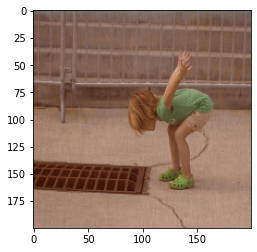

In [53]:
a = tr_images[12].to(device)
plt.imshow(a[-1].permute(1,2,0).cpu().numpy().astype('int32'))
print(a.shape,Xtr_c[12],Ytr_c[12])

In [84]:
model_encoder = ImageCaptionGeneratorEncoderModel(debug=False).to(device)
model_decoder = ImageCaptionGeneratorDecoderModel(
    batch_size,vocab_size,embedding_dim,num_lstm_layers,make_bidirectional,debug=False
).to(device)
epochs = 20
loss_fn = nn.NLLLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [85]:
optimizer_encoder = torch.optim.SGD(model_encoder.parameters(),lr=0.05)
optimizer_decoder = torch.optim.SGD(model_decoder.parameters(),lr=0.05)

In [86]:
def predict(model_encoder, model_decoder,image_tensor):
    model_encoder.eval()
    model_decoder.eval()
    with torch.no_grad():
        ht = model_encoder(image_tensor)
        c = torch.tensor([encode_decode.get_encoding('<')]).to(device)
        eos_index = char_to_index[">"]
        caption = []
        for i in range(100):
            if i==0: op,ht = model_decoder(c,ht,is_prev_state_image_encoding=True)
            else: op,ht = model_decoder(c,ht,is_prev_state_image_encoding=False)
            predicted_char = torch.argmax(op,axis=1).tolist()
            caption.append(predicted_char[-1])
            c = torch.tensor([predicted_char]).to(device)
            if predicted_char[-1] == eos_index: break
        print("Encoded Caption:",caption)
        print("Decoded Caption:",encode_decode.get_decoding(caption))

In [87]:
predict(model_encoder, model_decoder,a)

Encoded Caption: [26, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Decoded Caption: ,ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


In [93]:
for epoch in range(epochs):
    epoch_loss = 0
    model_encoder.train()
    model_decoder.train()
    for index,tr_image in enumerate(tr_images):
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        caption_index = 1#random.randint(0,4)
        ip_caption = Xtr_c[index][caption_index]
        op_caption = Ytr_c[index][caption_index]
        ip_c = torch.tensor([encode_decode.get_encoding(ip_caption)]).to(device)
        op_c = torch.tensor([encode_decode.get_encoding(op_caption)]).to(device)
        image = model_encoder(tr_image.to(device))
#         image = torch.randn(1,1,512).to(device)
        op,ht = model_decoder(ip_c,image,is_prev_state_image_encoding=True)
        loss = loss_fn(op,op_c.reshape(-1))
        epoch_loss += loss.item()
        loss.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()
        if index % 50 == 0: print("Epoch:",epoch,"Index:",index,"Loss:",loss.item())
    print("__________________________________________")
    print("Epoch loss........",epoch_loss)
    predict(model_encoder,model_decoder,a)
    print("__________________________________________")

Epoch: 0 Index: 0 Loss: 0.19373144209384918
Epoch: 0 Index: 50 Loss: 0.23210056126117706
Epoch: 0 Index: 100 Loss: 0.16454359889030457
Epoch: 0 Index: 150 Loss: 0.20437540113925934
Epoch: 0 Index: 200 Loss: 0.2178594470024109
Epoch: 0 Index: 250 Loss: 0.28090810775756836
Epoch: 0 Index: 300 Loss: 0.20603981614112854
Epoch: 0 Index: 350 Loss: 0.15033327043056488
Epoch: 0 Index: 400 Loss: 0.20127016305923462
__________________________________________
Epoch loss........ 86.27478339523077
Encoded Caption: [0, 1, 21, 10, 2, 0, 3, 1, 21, 4, 9, 23, 1, 16, 8, 0, 5, 5, 7, 5, 1, 4, 5, 1, 5, 7, 21, 4, 3, 16, 1, 19, 20]
Decoded Caption: a woman with glasses is sewing .>
__________________________________________
Epoch: 1 Index: 0 Loss: 0.18491870164871216
Epoch: 1 Index: 50 Loss: 0.22848452627658844
Epoch: 1 Index: 100 Loss: 0.19159641861915588
Epoch: 1 Index: 150 Loss: 0.2124488204717636
Epoch: 1 Index: 200 Loss: 0.2344420999288559
Epoch: 1 Index: 250 Loss: 0.24814727902412415
Epoch: 1 Index: 300

Epoch: 12 Index: 50 Loss: 0.20569968223571777
Epoch: 12 Index: 100 Loss: 0.1766815334558487
Epoch: 12 Index: 150 Loss: 0.16049045324325562
Epoch: 12 Index: 200 Loss: 0.23548507690429688
Epoch: 12 Index: 250 Loss: 0.20302844047546387
Epoch: 12 Index: 300 Loss: 0.20734690129756927
Epoch: 12 Index: 350 Loss: 0.10929351300001144
Epoch: 12 Index: 400 Loss: 0.16507700085639954
__________________________________________
Epoch loss........ 71.16506037861109
Encoded Caption: [0, 1, 21, 10, 2, 0, 3, 1, 21, 4, 9, 23, 1, 16, 8, 0, 5, 5, 7, 5, 1, 4, 5, 1, 5, 7, 21, 4, 3, 16, 1, 19, 20]
Decoded Caption: a woman with glasses is sewing .>
__________________________________________
Epoch: 13 Index: 0 Loss: 0.12974657118320465
Epoch: 13 Index: 50 Loss: 0.2144991010427475
Epoch: 13 Index: 100 Loss: 0.16179881989955902
Epoch: 13 Index: 150 Loss: 0.15912975370883942
Epoch: 13 Index: 200 Loss: 0.21094638109207153
Epoch: 13 Index: 250 Loss: 0.19149121642112732
Epoch: 13 Index: 300 Loss: 0.22486430406570435
E

### On Validation Data

In [ ]:
i = 24
img_name = Xval_i[i]
print(Xval_c[i],Yval_c[i])
im = plt.imread(image_folder+"/"+img_name)
resized_img = cv2.resize(im,(200,200),interpolation=cv2.INTER_AREA)
resized_img = torch.tensor([resized_img],dtype=torch.float)
resized_img = resized_img.permute(0,3,1,2)
resized_img = resized_img.to(device)
plt.imshow(resized_img[-1].permute(1,2,0).cpu().numpy().astype('int32'))

In [ ]:
predict(model_encoder, model_decoder,resized_img)